# MPRA interpretation using SHAP values to obtain contribution scores on background samples

### Environment
The next chunk contains the commands necessary to install the environment required to run this jupyter notebook
Skip this chunk if the installation was previously done. The github repo contains a yml file with the environment.

In [1]:
import os 
import getopt
import sys

import numpy as np
import h5py
import pickle
import random
import copy
import pandas as pd
import math 

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Layer, Dense, Dropout, Flatten, Conv1D,BatchNormalization,  MaxPooling1D
import tensorflow as tf


/home/felix/anaconda3/envs/DeepFlyBrain_conda_env_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/felix/anaconda3/envs/DeepFlyBrain_conda_env_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/felix/anaconda3/envs/DeepFlyBrain_conda_env_gpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.i

### One-hot-encoding

We define the method for one-hot-encoding, here we are not using the dataset class so we define the one-hot-encoder method outside of the dataset tensorflow framework
In this case the vocabulary is different compared to the normal contribution scores (we encode where there is no motif; lower cases)

In [2]:
# Prepare input data for deep explainer
df = pd.read_csv("/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/background_LibA_wide_pivot_state3_train_predicted_cv10fold.csv")

def one_hot_encode_sequences(sequences, max_length, vocab):
    """One hot encodes a sequence of characters

    Args:
        sequences (np.array): Input sequences 
        vocab (list): list of vocabulary characters

    Returns:
        (np.array): one-hot-encoded array
    """
    num_sequences = len(sequences)
    max_seq_length = max_length
    encoding = np.zeros((num_sequences, max_seq_length, len(vocab)), dtype=int)

    # Create a dictionary to map characters to their corresponding indices in the vocab
    char_to_index = {char: i for i, char in enumerate(vocab)}

    for i, sequence in enumerate(sequences):
        for j, base in enumerate(sequence):
            if base in char_to_index:
                index = char_to_index[base]
                encoding[i, j, index] = 1
            else:
                # Set the entire vector to [0, 0, 0, 0] for unexpected characters
                encoding[i, j, :] = [0, 0, 0, 0]

    return encoding

vocab = ["a", "c", "g", "t"]
max_length = df.seq.str.len().max()
X = one_hot_encode_sequences(df.seq.values, max_length,vocab)
y = df.State_3E.values
ids = df.CRS.values

### Model definition and loading of trained weights
Since for DeepExplainer we need an older tensorflow version we define the model and then load the weights (we can't load the model entirely since it comes from a different tensorflow version )

In [3]:

class CustomNormalization(Layer):
    def __init__(self, **kwargs):
        super(CustomNormalization, self).__init__(**kwargs)
        
    def build(self, input_shape):
        # Add trainable variables for mean and standard deviation
        self.mean = self.add_weight("mean", shape=(1,), initializer="zeros", trainable=True)
        self.stddev = self.add_weight("stddev", shape=(1,), initializer="ones", trainable=True)
        super(CustomNormalization, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs):
        # Normalize the inputs using the learned mean and standard deviation
        return (inputs - self.mean) / (self.stddev + 1e-8)

inputs = Input(shape=(X.shape[1], X.shape[2]), name="inputs")
#inputs = Masking()(inputs)
layer = Conv1D(250, kernel_size=7, strides=1, activation='relu', name="conv1")(inputs)  # 250 7 relu
layer = Dropout(0.3)(layer)
layer = BatchNormalization()(layer)
layer = Conv1D(250, 8, strides=1, activation='softmax', name="conv2")(layer)  # 250 8 softmax
layer = BatchNormalization()(layer)
layer = MaxPooling1D(pool_size=2, strides=None, name="maxpool1")(layer)
layer = Dropout(0.3)(layer)
layer = Conv1D(250, 3, strides=1, activation='softmax', name="conv3")(layer)  # 250 3 softmax
layer = BatchNormalization()(layer)
layer = Dropout(0.3)(layer)
layer = Conv1D(100, 2, strides=1, activation='softmax', name="conv4")(layer)  # 100 3 softmax
layer = BatchNormalization()(layer)
layer = MaxPooling1D(pool_size=1, strides=None, name="maxpool2")(layer)
layer = Dropout(0.3)(layer)
layer = Flatten()(layer)
layer = Dense(300, activation='sigmoid')(layer)  # 300
layer = Dropout(0.3)(layer)
layer = Dense(200, activation='sigmoid')(layer)  # 300
predictions = Dense(1, activation='linear')(layer)
norm_predictions = CustomNormalization()(predictions)  # Assuming "predictions" is your existing output

model = Model(inputs=inputs, outputs=norm_predictions)

model = Model(inputs=inputs, outputs=norm_predictions)
model.summary()
model.load_weights("/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/test_background.h5")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 262, 4)]          0         
_________________________________________________________________
conv1 (Conv1D)               (None, 256, 250)          7250      
_________________________________________________________________
dropout (Dropout)            (None, 256, 250)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 250)          1000      
_________________________________________________________________
conv2 (Conv1D)               (None, 249, 250)          500250    
_________________________________________________________________
batch_normalization_1 (Batch (None, 249, 250)          1000      
_________________________________________________________________
maxpool1 (MaxPooling1D)      (None, 124, 250)          0   

### Plotting methods

In [4]:
import matplotlib

def plot_a(ax, base, left_edge, height, color):
    a_polygon_coords = [
        np.array([
           [0.0, 0.0],
           [0.5, 1.0],
           [0.5, 0.8],
           [0.2, 0.0],
        ]),
        np.array([
           [1.0, 0.0],
           [0.5, 1.0],
           [0.5, 0.8],
           [0.8, 0.0],
        ]),
        np.array([
           [0.225, 0.45],
           [0.775, 0.45],
           [0.85, 0.3],
           [0.15, 0.3],
        ])
    ]
    for polygon_coords in a_polygon_coords:
        ax.add_patch(matplotlib.patches.Polygon((np.array([1,height])[None,:]*polygon_coords
                                                 + np.array([left_edge,base])[None,:]),
                                                facecolor=color, edgecolor=color))

def plot_c(ax, base, left_edge, height, color):
    ax.add_patch(matplotlib.patches.Ellipse(xy=[left_edge+0.65, base+0.5*height], width=1.3, height=height,
                                            facecolor=color, edgecolor=color))
    ax.add_patch(matplotlib.patches.Ellipse(xy=[left_edge+0.65, base+0.5*height], width=0.7*1.3, height=0.7*height,
                                            facecolor='white', edgecolor='white'))
    ax.add_patch(matplotlib.patches.Rectangle(xy=[left_edge+1, base], width=1.0, height=height,
                                            facecolor='white', edgecolor='white', fill=True))

def plot_g(ax, base, left_edge, height, color):
    ax.add_patch(matplotlib.patches.Ellipse(xy=[left_edge+0.65, base+0.5*height], width=1.3, height=height,
                                            facecolor=color, edgecolor=color))
    ax.add_patch(matplotlib.patches.Ellipse(xy=[left_edge+0.65, base+0.5*height], width=0.7*1.3, height=0.7*height,
                                            facecolor='white', edgecolor='white'))
    ax.add_patch(matplotlib.patches.Rectangle(xy=[left_edge+1, base], width=1.0, height=height,
                                            facecolor='white', edgecolor='white', fill=True))
    ax.add_patch(matplotlib.patches.Rectangle(xy=[left_edge+0.825, base+0.085*height], width=0.174, height=0.415*height,
                                            facecolor=color, edgecolor=color, fill=True))
    ax.add_patch(matplotlib.patches.Rectangle(xy=[left_edge+0.625, base+0.35*height], width=0.374, height=0.15*height,
                                            facecolor=color, edgecolor=color, fill=True))

def plot_t(ax, base, left_edge, height, color):
    ax.add_patch(matplotlib.patches.Rectangle(xy=[left_edge+0.4, base],
                  width=0.2, height=height, facecolor=color, edgecolor=color, fill=True))
    ax.add_patch(matplotlib.patches.Rectangle(xy=[left_edge, base+0.8*height],
                  width=1.0, height=0.2*height, facecolor=color, edgecolor=color, fill=True))

default_colors = {0:'green', 1:'blue', 2:'orange', 3:'red'}
default_plot_funcs = {0:plot_a, 1:plot_c, 2:plot_g, 3:plot_t}

default_colors = {0:'green', 1:'blue', 2:'orange', 3:'red'}
default_plot_funcs = {0:plot_a, 1:plot_c, 2:plot_g, 3:plot_t}

def plot_weights_given_ax(ax, array,
                 height_padding_factor,
                 length_padding,
                 subticks_frequency,
                 highlight,
                 colors=default_colors,
                 plot_funcs=default_plot_funcs):
    if len(array.shape)==3:
        array = np.squeeze(array)
    assert len(array.shape)==2, array.shape
    if (array.shape[0]==4 and array.shape[1] != 4):
        array = array.transpose(1,0)
    assert array.shape[1]==4
    max_pos_height = 0.0
    min_neg_height = 0.0
    heights_at_positions = []
    depths_at_positions = []
    for i in range(array.shape[0]):
        acgt_vals = sorted(enumerate(array[i,:]), key=lambda x: abs(x[1]))
        positive_height_so_far = 0.0
        negative_height_so_far = 0.0
        for letter in acgt_vals:
            plot_func = plot_funcs[letter[0]]
            color=colors[letter[0]]
            if (letter[1] > 0):
                height_so_far = positive_height_so_far
                positive_height_so_far += letter[1]                
            else:
                height_so_far = negative_height_so_far
                negative_height_so_far += letter[1]
            plot_func(ax=ax, base=height_so_far, left_edge=i, height=letter[1], color=color)
        max_pos_height = max(max_pos_height, positive_height_so_far)
        min_neg_height = min(min_neg_height, negative_height_so_far)
        heights_at_positions.append(positive_height_so_far)
        depths_at_positions.append(negative_height_so_far)
    for color in highlight:
        for start_pos, end_pos in highlight[color]:
            assert start_pos >= 0.0 and end_pos <= array.shape[0]
            min_depth = np.min(depths_at_positions[start_pos:end_pos])
            max_height = np.max(heights_at_positions[start_pos:end_pos])
            ax.add_patch(
                matplotlib.patches.Rectangle(xy=[start_pos,min_depth],
                    width=end_pos-start_pos,
                    height=max_height-min_depth,
                    edgecolor=color, fill=False))
            
    ax.set_xlim(-length_padding, array.shape[0]+length_padding)
    ax.xaxis.set_ticks(np.arange(0.0, array.shape[0]+1, subticks_frequency))
    height_padding = max(abs(min_neg_height)*(height_padding_factor),
                         abs(max_pos_height)*(height_padding_factor))
    ax.set_ylim(min_neg_height-height_padding, max_pos_height+height_padding)
    return ax

def plot_weights_modified(array, fig, n,n1,n2, title='', ylab='',
                              figsize=(20,2),
                 height_padding_factor=0.2,
                 length_padding=1.0,
                 subticks_frequency=20,
                 colors=default_colors,
                 plot_funcs=default_plot_funcs,
                 highlight={}):
    ax = fig.add_subplot(n,n1,n2) 
    ax.set_title(title)
    ax.set_ylabel(ylab)
    y = plot_weights_given_ax(ax=ax, array=array,
        height_padding_factor=height_padding_factor,
        length_padding=length_padding,
        subticks_frequency=subticks_frequency,
        colors=colors,
        plot_funcs=plot_funcs,
        highlight=highlight)
    return fig,ax


### Initialize Deep Explainer

Deep explainer is an approximation of shap values, the output prediction is decomposed by backpropagating the contributions of all networks to every input feature.

In [5]:
import shap

rn=np.random.choice([X,  X[:,::-1,::-1]][0].shape[0], 1000, replace=False)
explainer = shap.DeepExplainer((model.inputs, model.layers[-1].output), X[rn])

if os.path.exists("/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/deep_explainer_background/") is False:
    os.mkdir("/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/deep_explainer_background/")

In /home/felix/anaconda3/envs/DeepFlyBrain_conda_env_gpu/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/felix/anaconda3/envs/DeepFlyBrain_conda_env_gpu/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/felix/anaconda3/envs/DeepFlyBrain_conda_env_gpu/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/felix/anaconda3/envs/DeepFlyBrain_conda_env_gpu/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated 

Using TensorFlow backend.


In [6]:
import matplotlib.pyplot as plt
shap_values, indexes = explainer.shap_values(X, ranked_outputs=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [9]:
shap_values

[array([[[ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.]],
 
        [[nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         ...,
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan]],
 
        [[nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         ...,
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan]],
 
        ...,
 
        [[nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         ...,
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan]],
 
        [[nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         ...,
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan]],
 
        [[nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         ...,
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan]]])]

In [7]:
shap_values

[array([[[ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.]],
 
        [[nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         ...,
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan]],
 
        [[nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         ...,
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan]],
 
        ...,
 
        [[nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         ...,
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan]],
 
        [[nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         ...,
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan]],
 
        [[nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         ...,
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan]]])]

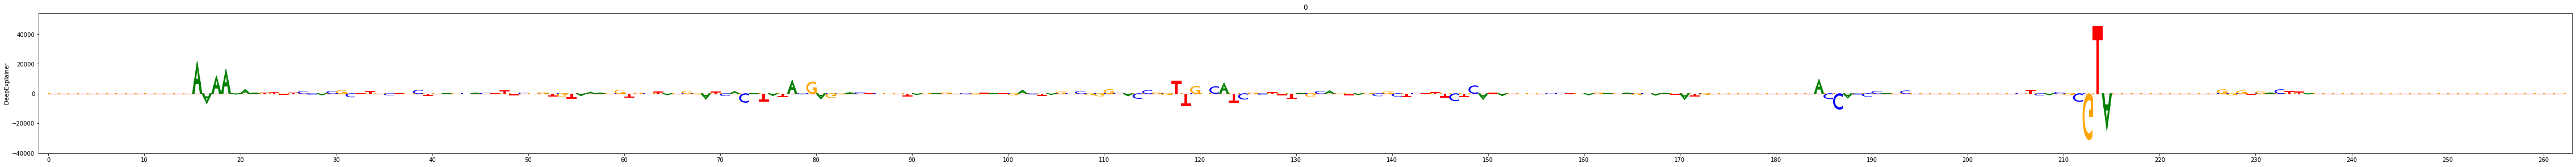

In [10]:
# For each observation, we plot the importance scores
for i in range(0, X.shape[0]):
    ntrack=2
    fig = plt.figure(figsize=(80,10))
    _, ax1 =plot_weights_modified(shap_values[0][0]*X[i],fig,ntrack,1,1,title=i, subticks_frequency=10,ylab="DeepExplainer")
    break
    plt.savefig("/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/deep_explainer_background/"+ids[i] +'_deep_explainer.png')
    plt.close('all')